# Machine Learning

In [16]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt


import cv 
import importlib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as PipelineIMB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import utils

import joblib



In [3]:
pd.set_option("display.max_colwidth", None)

In [4]:
data = pd.read_csv("dados/pos_analyse.csv", encoding='latin1')

In [5]:
data.drop("Unnamed: 0", axis=1, inplace= True)

In [32]:
data.head()

,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,...,is_weekend,is_holiday,season,AVERAGE_SPEED_DIFF_N,LUMINOSITY_N,AVERAGE_CLOUDINESS_N,is_peak_hour,poor_visibility,hour_weekday,time_ratio
0,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,...,0,0,Summer,1.0,2,NaN,1,0,79,0.161064
1,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,...,0,0,Summer,2.0,2,1.0,1,0,110,0.552632
2,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,...,1,0,Summer,2.0,2,NaN,1,0,160,0.450704
3,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,4.0,...,0,0,Winter,2.0,2,1.0,1,0,35,0.648247
4,2019-06-06 12:00:00,Medium,41.6,50.4,77.0,LIGHT,15.0,1008.0,82.0,10.0,...,0,0,Spring,1.0,2,NaN,1,0,84,0.654545


In [33]:
data.shape

(6812, 26)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   record_date              6812 non-null   object 
 1   AVERAGE_SPEED_DIFF       4612 non-null   object 
 2   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 3   AVERAGE_TIME_DIFF        6812 non-null   float64
 4   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 5   LUMINOSITY               6812 non-null   object 
 6   AVERAGE_TEMPERATURE      6812 non-null   float64
 7   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 8   AVERAGE_HUMIDITY         6812 non-null   float64
 9   AVERAGE_WIND_SPEED       6812 non-null   float64
 10  AVERAGE_CLOUDINESS       4130 non-null   object 
 11  year                     6812 non-null   int64  
 12  month                    6812 non-null   int64  
 13  day                      6812 non-null   int64  
 14  hour                    

In [6]:
data = data.dropna(subset=["AVERAGE_SPEED_DIFF_N"])
data.shape

(4612, 26)

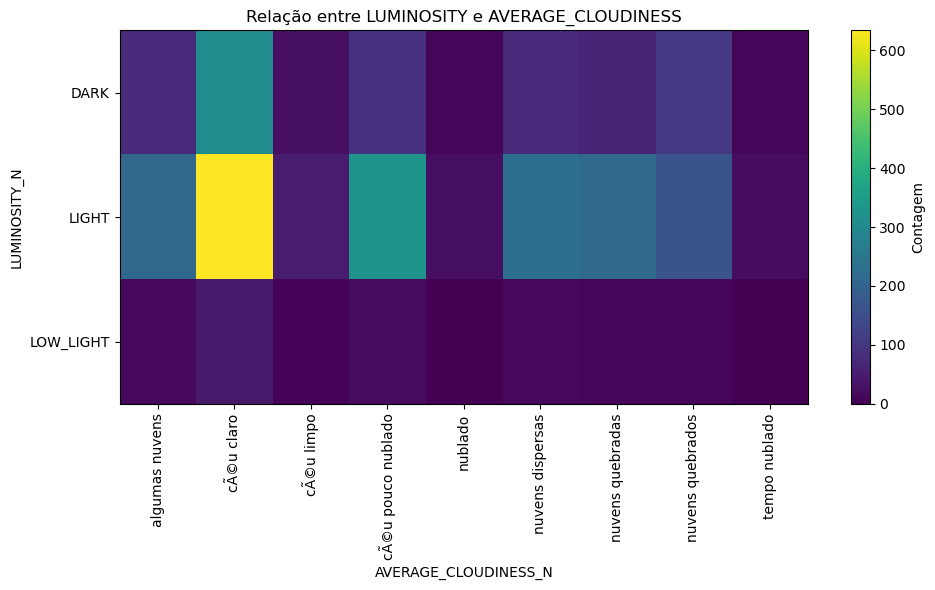

In [48]:
ct = pd.crosstab(data["LUMINOSITY"], data["AVERAGE_CLOUDINESS"])

plt.figure(figsize=(10, 6))
plt.imshow(ct, aspect='auto')
plt.colorbar(label='Contagem')

plt.xticks(range(len(ct.columns)), ct.columns, rotation=90)
plt.yticks(range(len(ct.index)), ct.index)

plt.xlabel("AVERAGE_CLOUDINESS_N")
plt.ylabel("LUMINOSITY_N")
plt.title("Relação entre LUMINOSITY e AVERAGE_CLOUDINESS")

plt.tight_layout()
plt.show()

In [7]:

def preencher_cloudiness(row):
    if pd.notna(row["AVERAGE_CLOUDINESS_N"]):
        return row["AVERAGE_CLOUDINESS_N"]
    
    if row["LUMINOSITY_N"] == 2: # light
        return 1   # céu claro
    
    if row["LUMINOSITY_N"] == 0: # dark
        return 7   # nublado
    
    if row["LUMINOSITY_N"] == 1: #LOW_LIGHT
        return 3 # algumas nuvens

data["AVERAGE_CLOUDINESS_N"] = data.apply(preencher_cloudiness, axis=1)


In [50]:
data.isna().sum()

record_date                   0
AVERAGE_SPEED_DIFF            0
AVERAGE_FREE_FLOW_SPEED       0
AVERAGE_TIME_DIFF             0
AVERAGE_FREE_FLOW_TIME        0
LUMINOSITY                    0
AVERAGE_TEMPERATURE           0
AVERAGE_ATMOSP_PRESSURE       0
AVERAGE_HUMIDITY              0
AVERAGE_WIND_SPEED            0
AVERAGE_CLOUDINESS         1839
year                          0
month                         0
day                           0
hour                          0
weekday                       0
is_weekend                    0
is_holiday                    0
season                        0
AVERAGE_SPEED_DIFF_N          0
LUMINOSITY_N                  0
AVERAGE_CLOUDINESS_N          0
is_peak_hour                  0
poor_visibility               0
hour_weekday                  0
time_ratio                    0
dtype: int64

In [8]:
data["record_date"] = pd.to_datetime(data["record_date"])

In [9]:
data = data.sort_values(by='record_date')


In [10]:
data.columns

Index(['record_date', 'AVERAGE_SPEED_DIFF', 'AVERAGE_FREE_FLOW_SPEED',
       'AVERAGE_TIME_DIFF', 'AVERAGE_FREE_FLOW_TIME', 'LUMINOSITY',
       'AVERAGE_TEMPERATURE', 'AVERAGE_ATMOSP_PRESSURE', 'AVERAGE_HUMIDITY',
       'AVERAGE_WIND_SPEED', 'AVERAGE_CLOUDINESS', 'year', 'month', 'day',
       'hour', 'weekday', 'is_weekend', 'is_holiday', 'season',
       'AVERAGE_SPEED_DIFF_N', 'LUMINOSITY_N', 'AVERAGE_CLOUDINESS_N',
       'is_peak_hour', 'poor_visibility', 'hour_weekday', 'time_ratio'],
      dtype='object')

### Treino e Teste

In [10]:
X = data[['AVERAGE_FREE_FLOW_SPEED',
       'AVERAGE_TIME_DIFF', 'AVERAGE_FREE_FLOW_TIME',
       'AVERAGE_TEMPERATURE', 'AVERAGE_ATMOSP_PRESSURE', 'AVERAGE_HUMIDITY',
       'AVERAGE_WIND_SPEED', 'year', 'month', 'day',
       'hour', 'weekday', 'is_weekend', 'is_holiday', 'season', 'LUMINOSITY_N', 'AVERAGE_CLOUDINESS_N',
       'is_peak_hour', 'poor_visibility', 'hour_weekday', 'time_ratio']]

y = data['AVERAGE_SPEED_DIFF_N']

#X = X.dropna()
#y = y.loc[X.index]

# Time-Based Split 
cutoff = data['record_date'].quantile(0.70)  
train_mask = data['record_date'] <= cutoff

X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = n, stratify=y)

print(f"Datas do treino: {data[train_mask]['record_date'].min()} a {data[train_mask]['record_date'].max()}")
print(f"Datas do teste: {data[~train_mask]['record_date'].min()} a {data[~train_mask]['record_date'].max()}")

Datas do treino: 2018-07-24 15:00:00 a 2019-06-15 17:00:00
Datas do teste: 2019-06-15 18:00:00 a 2019-09-30 18:00:00


### Pipeline

In [11]:
'''O CatBoostEncoder substitui valores categóricos por uma versão suavizada da média da variável alvo (target mean encoding), levando em consideração a distribuição da variável alvo para evitar overfitting'''

def f_preprocessor (X: pd.DataFrame):
    cols_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cols_cat = X.select_dtypes(include=['object', 'category']).columns.tolist()

    pipe_cat = Pipeline([('encoder', CatBoostEncoder())])#Pipeline([('encoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))])
    pipe_num = Pipeline([('std_scaler', StandardScaler())])

    preprocessor = ColumnTransformer([('numeric', pipe_num, cols_num), #'passthrough'
                                    ('categoric', pipe_cat, cols_cat)])
    return preprocessor

preprocessor = f_preprocessor(X)

### Cross Validation (treino)

In [57]:
importlib.reload(cv)
df_over = cv.cross_validation_models_set_class('Default', preprocessor, X_train, y_train)
df_over.sort_values('F1-Score', ascending = False)

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score,Kappa
8,CatBoost,0.960,0.816,0.819,0.828,0.823,0.743
3,Random Forest,0.959,0.811,0.822,0.814,0.817,0.735
11,HistGradientBoosting,0.957,0.811,0.819,0.815,0.816,0.735
9,Balanced Random Forest,0.957,0.805,0.809,0.821,0.813,0.728
6,LightGBM,0.958,0.806,0.814,0.810,0.811,0.728
7,XGBoost,0.957,0.802,0.811,0.810,0.810,0.724
4,Gradient Boosting,0.956,0.804,0.812,0.809,0.810,0.726
0,Regressão Logística,0.950,0.788,0.796,0.783,0.789,0.702
12,MLP (Neural Network),0.949,0.782,0.793,0.781,0.786,0.694
5,Support Vector Machine,0.947,0.776,0.792,0.778,0.784,0.685


### Tuning

In [60]:


n = 42

decision_tree_params = {
    'model__criterion': ['gini', 'entropy'],  
    'model__max_depth': [None, 5, 10, 20], 
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4]  
}

random_forest_params = {
    'model__n_estimators': [100, 200],  
    'model__criterion': ['gini', 'entropy'], 
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False] 
}

balanced_random_forest_params = {
    'model__n_estimators': [100, 200],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False],
    'model__sampling_strategy': ['auto', 0.5, 0.75],  # Controle do balanceamento
    'model__replacement': [True, False],  # Amostragem com/sem reposição
    'model__class_weight': [None, 'balanced', 'balanced_subsample']
}

gradient_boosting_params = {
    'model__learning_rate': [0.1, 0.01],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4, 5]
}

logistic_regression_params = {
    'model__C': [0.1, 1, 10],  # regularização
    'model__penalty': ['l1', 'l2'],  # tipo de regularização
    'model__solver': ['liblinear']  
}

# Parâmetros para SVM
svm_params = {
    'model__C': [0.1, 1, 10],  
    'model__kernel': ['linear', 'rbf'],  
    'model__gamma': ['scale', 'auto']  # Coeficiente para kernel 'rbf'
}



knn_params = {
    'model__n_neighbors': [3, 5, 7, 10],  # Número de vizinhos a serem considerados
    'model__weights': ['uniform', 'distance'],  # Peso dado aos vizinhos
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo usado para encontrar os vizinhos
    'model__leaf_size': [20, 30, 40],  # Tamanho das folhas (afeta a eficiência)
    'model__p': [1, 2]  # Tipo de distância (1 = Manhattan, 2 = Euclidiana)
}


# Parâmetros para LightGBM
lightgbm_params = {
    'model__num_leaves': [31, 50, 100],          # Número máximo de folhas em uma árvore
    'model__max_depth': [-1, 5, 10],             # Profundidade máxima (-1 significa sem limite)
    'model__learning_rate': [0.1, 0.01, 0.001],  # Taxa de aprendizado
    'model__n_estimators': [100, 200],           # Número de árvores
    'model__min_child_samples': [20, 50],        # Número mínimo de dados em uma folha
    'model__subsample': [0.8, 1.0],              # Fração de amostras para treino
    'model__colsample_bytree': [0.8, 1.0],       # Fração de features para construir cada árvore
    'model__reg_alpha': [0, 0.1],                # Regularização L1
    'model__reg_lambda': [0, 0.1],               # Regularização L2
    'model__boosting_type': ['gbdt', 'dart']      # Tipo de boosting
}

xgb_params = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__n_estimators': [100, 200],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [1, 0.1],
    'model__min_child_weight': [1, 5],
    'model__tree_method': ['hist']  # Faster for medium-sized datasets
}

catboost_params = {
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__iterations': [100, 200],
    'model__l2_leaf_reg': [1, 3, 5],
    'model__border_count': [32, 64],
    'model__grow_policy': ['SymmetricTree'],  
    'model__auto_class_weights': ['Balanced'], 
    'model__boosting_type': ['Ordered']
}

mlp_params = {
    'model__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'model__activation': ['relu', 'tanh'],  # 'logistic' também é possível
    'model__solver': ['adam'],  
    'model__alpha': [0.0001, 0.001, 0.01],  # Regularização L2
    'model__learning_rate_init': [0.001, 0.01],  # Taxa de aprendizado inicial
    'model__max_iter': [200, 300],
    'model__early_stopping': [True],  # Para evitar overfitting
    'model__random_state': [42]  # Para reprodutibilidade
}

easy_ensemble_params = {
    'model__n_estimators': [10, 30, 50, 100],
    'model__estimator': [DecisionTreeClassifier(max_depth=5)],  # Removed None
    'model__warm_start': [True, False],
    'model__sampling_strategy': ['auto', 0.5, 0.75, 1.0],
    'model__replacement': [True, False],
    'model__random_state': [None, 42],
    'model__estimator__criterion': ['gini', 'entropy'],
    'model__estimator__max_depth': [None, 5, 10],
    'model__estimator__min_samples_split': [2, 5, 10],
    'model__estimator__min_samples_leaf': [1, 2, 4]
}




modelos = {
    #'Gradient Boosting': (GradientBoostingClassifier(random_state=n), gradient_boosting_params),
    #'Regressão Logística': (LogisticRegression(random_state=n, max_iter=1000), logistic_regression_params),
    #'SVM': (SVC(random_state=n, probability=True), svm_params),
    # 'KNN': (KNeighborsClassifier(), knn_params),
    #'MLP' : (MLPClassifier(),mlp_params),
    #'XGBoost': (XGBClassifier(random_state=n), xgb_params),
    #'LightGBM': (LGBMClassifier(random_state=n), lightgbm_params)
    #'Decision Tree': (DecisionTreeClassifier(random_state=n), decision_tree_params)
    'Random Forest': (RandomForestClassifier(random_state=n), random_forest_params),
    'CatBoost': (CatBoostClassifier(random_state=n, verbose=0, auto_class_weights='Balanced'), catboost_params),
    #'Balanced Random Forest': (BalancedRandomForestClassifier(random_state=n), balanced_random_forest_params),
    #'Easy Ensemble': (EasyEnsembleClassifier(random_state=42), easy_ensemble_params)

}


In [61]:
importlib.reload(cv)
gs = cv.hyperparameter_optimization(None,preprocessor, X_train, y_train, modelos)

In [66]:
gs

,model,F1_macro,Recall_macro,Precision_macro,Best_params
0,Random Forest,0.800363,0.799502,0.807914,"{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}"
1,CatBoost,0.806984,0.816585,0.803567,"{'model__auto_class_weights': 'Balanced', 'model__boosting_type': 'Ordered', 'model__border_count': 64, 'model__depth': 8, 'model__grow_policy': 'SymmetricTree', 'model__iterations': 200, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.1}"


### Teste

In [12]:
n = 42

catboost = CatBoostClassifier(auto_class_weights= 'Balanced', boosting_type ='Ordered', border_count =64, depth =8, grow_policy = 'SymmetricTree', iterations = 200, l2_leaf_reg= 5, learning_rate= 0.1)
pipe_cb = PipelineIMB([
    ('preprocessor', preprocessor),
    ('model', catboost)
])


randomforest = RandomForestClassifier(bootstrap = False, criterion = 'gini', max_depth =10, min_samples_leaf =1, min_samples_split= 2, n_estimators= 100)
pipe_rf = PipelineIMB([
    ('preprocessor', preprocessor),
    ('model', randomforest)
])

#### Treinos

pipe_cb.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
 


0:	learn: 1.2469057	total: 123ms	remaining: 24.5s
1:	learn: 1.1345340	total: 153ms	remaining: 15.1s
2:	learn: 1.0573921	total: 178ms	remaining: 11.7s
3:	learn: 0.9839437	total: 201ms	remaining: 9.86s
4:	learn: 0.9226309	total: 224ms	remaining: 8.74s
5:	learn: 0.8713024	total: 247ms	remaining: 7.98s
6:	learn: 0.8245205	total: 269ms	remaining: 7.42s
7:	learn: 0.7826703	total: 291ms	remaining: 6.99s
8:	learn: 0.7477021	total: 313ms	remaining: 6.64s
9:	learn: 0.7176811	total: 335ms	remaining: 6.37s
10:	learn: 0.6934644	total: 362ms	remaining: 6.21s
11:	learn: 0.6686134	total: 384ms	remaining: 6.02s
12:	learn: 0.6449086	total: 406ms	remaining: 5.84s
13:	learn: 0.6235210	total: 431ms	remaining: 5.72s
14:	learn: 0.6039103	total: 455ms	remaining: 5.61s
15:	learn: 0.5888296	total: 480ms	remaining: 5.52s
16:	learn: 0.5729208	total: 507ms	remaining: 5.46s
17:	learn: 0.5583179	total: 535ms	remaining: 5.41s
18:	learn: 0.5465989	total: 559ms	remaining: 5.33s
19:	learn: 0.5356413	total: 586ms	remaini

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
predictions_rf = pipe_rf.predict(X_test)
predictions_p_rf =  pipe_rf.predict_proba(X_test)[:, 1] 

predictions_cb = pipe_cb.predict(X_test)
predictions_p_cb =  pipe_cb.predict_proba(X_test)[:, 1]

In [15]:
rf_report = classification_report(y_test, predictions_rf)
print("Relatório de Classificação RF:")
print(rf_report)

Relatório de Classificação RF:
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       439
         1.0       0.78      0.69      0.73       488
         2.0       0.72      0.75      0.74       335
         3.0       0.76      0.65      0.70       122

    accuracy                           0.77      1384
   macro avg       0.77      0.75      0.76      1384
weighted avg       0.77      0.77      0.77      1384



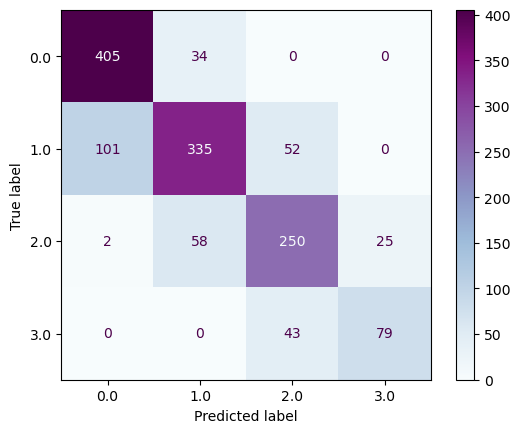

In [16]:
cm = confusion_matrix(y_test, predictions_rf, labels=pipe_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = pipe_rf.classes_)
disp = disp.plot(cmap = plt.cm.BuPu)
plt.grid(False)

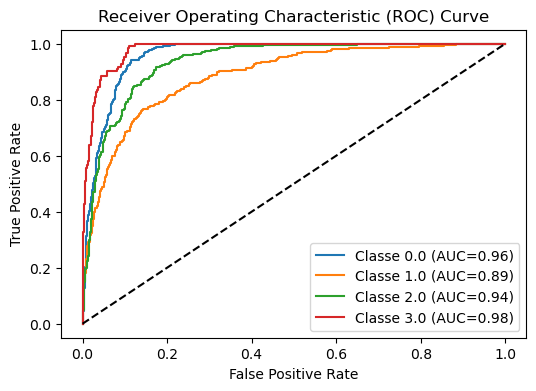

In [76]:
cv.curva_roc(X_test, y_test, pipe_rf)

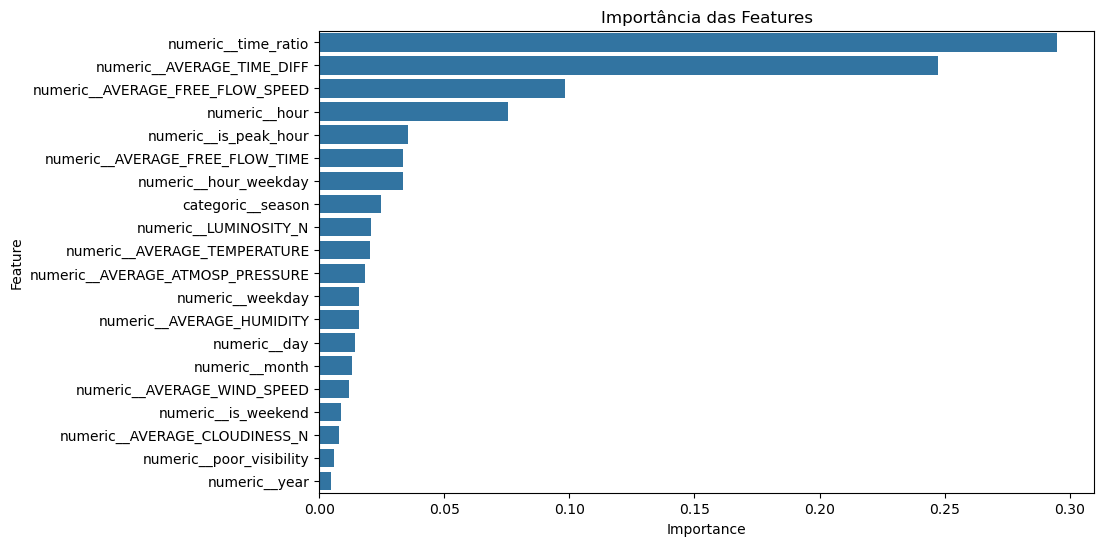

In [15]:
importlib.reload(utils)
#utils.shap_tree(preprocessor, X, X_test, pipe_cb)
utils.feature_importance(pipe_rf)

In [17]:
rf_report = classification_report(y_test, predictions_cb)
print("Relatório de Classificação CB:")
print(rf_report)

Relatório de Classificação CB:
              precision    recall  f1-score   support

         0.0       0.78      0.92      0.84       439
         1.0       0.80      0.63      0.70       488
         2.0       0.71      0.76      0.73       335
         3.0       0.72      0.74      0.73       122

    accuracy                           0.76      1384
   macro avg       0.75      0.76      0.75      1384
weighted avg       0.76      0.76      0.76      1384



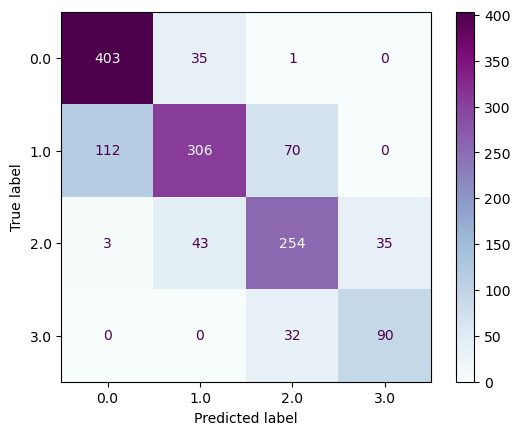

In [75]:
cm = confusion_matrix(y_test, predictions_cb, labels=pipe_cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = pipe_cb.classes_)
disp = disp.plot(cmap = plt.cm.BuPu)
plt.grid(False)

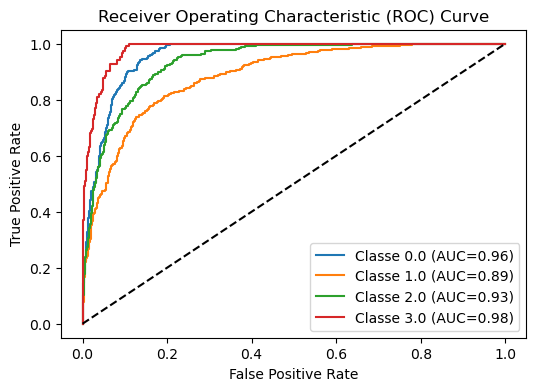

In [77]:
cv.curva_roc(X_test, y_test, pipe_cb)

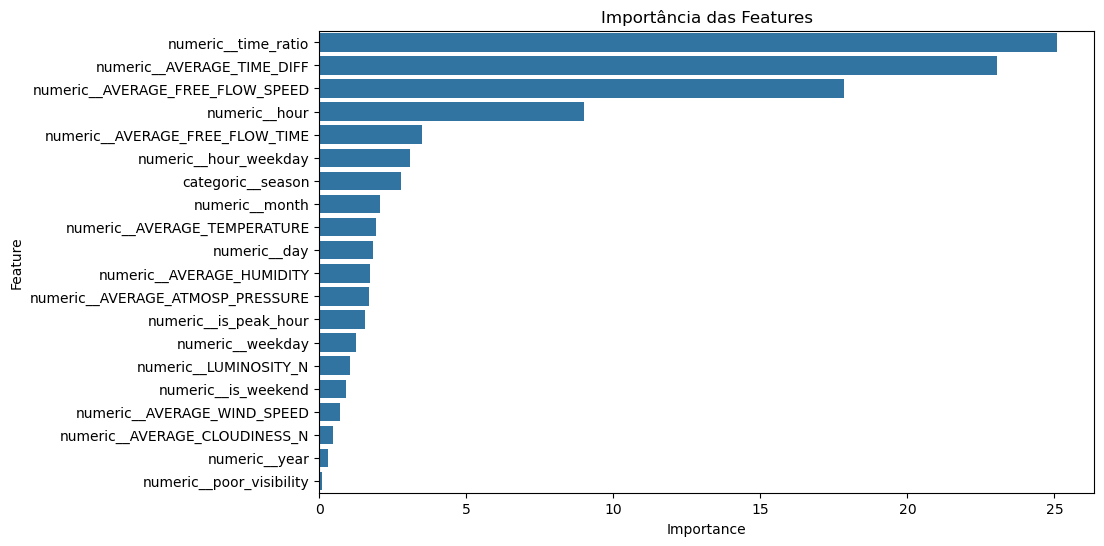

In [14]:
importlib.reload(utils)
#utils.shap_tree(preprocessor, X, X_test, pipe_cb)
utils.feature_importance(pipe_cb)

### Salvar Modelos

In [17]:
pipeline_final = PipelineIMB([('preprocessor', preprocessor), 
                              ('model', randomforest)])
joblib.dump(pipeline_final, 'modelos/random_forest_c1.pkl')

['modelos/random_forest_c1.pkl']

In [18]:
pipeline_final = PipelineIMB([('preprocessor', preprocessor), 
                              ('model', catboost)])
joblib.dump(pipeline_final, 'modelos/catboost_c1.pkl')

['modelos/catboost_c1.pkl']